# RFM-анализ

In [14]:
import pandahouse as ph
import pandas as pd

Нужно написать функцию, которая будет отправлять текст SQL-запроса, в нашем случае - запроса к ClickHouse, на сервер, а по выполнении запроса забирать его результаты в каком-то виде.

In [9]:
connection = {'host': 'http://clickhouse.beslan.pro:8080/',
                      #'database':'test',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

RFM-анализ, в основе которого лежат поведенческие факторы групп или сегментов клиентов. Данный метод анализа позволяет изучить поведение пользователей и то, как они совершают платежи. В результате вы получите ценные инсайты по построению директ-маркетинга для вашей компании.​ Также RFM-сегментация поможет вам применять в коммуникациях особый подход к каждой группе клиентов.

## Что такое RFM-анализ и зачем он нужен маркетологу
RFM-анализ — метод анализа, позволяющий сегментировать клиентов по частоте и сумме покупок и выявлять тех, которые приносят больше денег.

Аббревиатура RFM расшифровывается:

- Recency — давность (как давно ваши клиенты что-то у вас покупали);
- Frequency — частота (как часто они у вас покупают);
- Monetary — деньги (общая сумма покупок).

По этим признакам можно разделить всех ваших клиентов на группы, понять, кто покупает у вас часто и много, кто — часто, но мало, а кто вообще давно ничего не покупал.

Как правило, небольшой процент пользователей реагирует на общие рекламные предложения. RFM-анализ и RFM-сегментация являются отличным методом прогнозирования реакции клиента и улучшения взаимодействия, а также повышение прибыли. RFM использует поведение покупателей, чтобы определить, как работать с каждой группой клиентов. 

Суть RFM-анализа в том, что мы разделяем всех клиентов на группы, в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. По каждому из этих признаков мы выделяем по три равные группы. Затем присваиваем каждой группе числовое обозначение от 1 до 3.

**По давности заказа:**

- 1 — давние клиенты;
- 2 — относительно недавние клиенты;
- 3 — недавние клиенты.

**По частоте покупок:**

- 1 — покупает очень редко (единичные заказы);​
- 2 — покупает нечасто;
- 3 — покупает часто.

**По сумме покупок:**

- 1 — маленькая сумма покупок;
- 2 — средняя сумма покупок;
- 3 — большая сумма покупок.

Например, клиент «111» покупал давно, один раз и на маленькую сумму. Или клиент «333»: покупает часто, на большую сумму и последняя покупка была недавно. Это ваши лучшие клиенты.

In [248]:
# Запрос к БД в ClickHouse
query = """
  SELECT UserID, COUNT(UserID) AS purchases, SUM(Rub) AS revenue, MAX(BuyDate) AS date
  FROM checks
  WHERE BuyDate > '2018-12-31' AND Rub > 0
  GROUP BY UserID
  LIMIT 1000000
"""
df = ph.read_clickhouse(query=query, connection=connection)

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000000 non-null  uint64
 1   purchases  1000000 non-null  uint64
 2   revenue    1000000 non-null  uint64
 3   date       1000000 non-null  object
dtypes: object(1), uint64(3)
memory usage: 30.5+ MB


In [250]:
df.head()

,UserID,purchases,revenue,date
0,16308669351351992594,1,7,2019-01-19
1,17633373436558009457,36,205,2019-06-14
2,1427202562713834276,5,95,2019-02-08
3,13579452322145411620,1,42,2019-05-14
4,8674668169880158265,1,2,2019-01-03


In [251]:
df.date = pd.to_datetime(df.date)

In [244]:
df.UserID.nunique()

1000000

- определить последнюю дату покупки каждого клиента
- посчитать сколько раз заказывал каждый клиент
- общую сумму по каждому клиенту

In [161]:
rfm = df.assign(Count=1).groupby('UserID') \
              .agg({'BuyDate': max, 'Rub': sum, 'Count': sum}).reset_index()

С помощью формулы `TODAY()` - дата последней покупки мы рассчитываем какое количество дней назад были совершены последние покупки. Это и будут данные по нашей R(Recency) 

In [252]:
today = pd.Timestamp('2020') # возьмем начало 2020 для точки отсчета, а не pd.Timestamp.today()
df['days_from_now'] = (today - df['date']).dt.days

In [253]:
df

,UserID,purchases,revenue,date,days_from_now
0,16308669351351992594,1,7,2019-01-19,347
1,17633373436558009457,36,205,2019-06-14,201
2,1427202562713834276,5,95,2019-02-08,327
3,13579452322145411620,1,42,2019-05-14,232
4,8674668169880158265,1,2,2019-01-03,363
...,...,...,...,...,...
999995,16172966979666432099,2,5,2019-04-28,248
999996,1071803333472938398,1,29,2019-03-15,292
999997,13640354622859418165,1,4,2019-08-28,126
999998,960080279955027453,5,41,2019-03-28,279


In [254]:
# rfm.rename(columns={'BuyDate': 'R', 'Count': 'F', 'Rub': 'M'}, inplace=True)

У нас есть все данные по Recency, Frequency (количество заказов) и Monetary (сумма). Сейчас мы будем присваивать значения от 1 до 3 (о чем мы уже говорили чуть выше) в соответствии с этими данными.

Начнем со значений для Recency. Первое, что нам нужно, это рассчитать как давно у нас покупали 33% и 66% клиентов.

In [258]:
df['days_from_now'].quantile([.33, .66])

0.33    145.0
0.66    264.0
Name: days_from_now, dtype: float64

Теперь мы знаем, что 33% клиентов покупали наши товары менее 145 дней назад, а 66% — более 264 дней назад.

Соответственно, тем клиентам, кто покупал менее, чем 145 дней назад мы присваиваем наивысшее значение - 3. Тем, кто делал заказ от 145 до 264 дней назад - 2. И остальным, кто покупал более чем 228 дня назад мы присваиваем значение 1. 

Мы можем и нарезать квантили `pd.qcut(df['days_from_now'], q=3, labels=range(3, 0, -1))`

In [259]:
df['R'] = pd.qcut(df['days_from_now'], 3, labels=range(3, 0, -1))

По такому же принципу просчитываем значения для F(Frequency) и M(Mmonetary): сначала вычисляем сколько раз покупали 33% и 66% клиентов и по результатам проставляем значения от 1 до 3.

In [260]:
df['purchases'].quantile([.33, .66]) # видим что большая часть пользователей совершила только одну покупку

0.33    2.0
0.66    6.0
Name: purchases, dtype: float64

In [262]:
df['F'] = pd.qcut(df['purchases'], 3, labels=range(1, 4))

In [263]:
df['revenue'].quantile([.33, .66])

0.33    11.0
0.66    56.0
Name: revenue, dtype: float64

In [265]:
df['M'] = pd.qcut(df['revenue'], 3, labels=range(1, 4))

И для большей наглядности нам осталось просчитать общее значение RFM, объединив все 3 значения по каждому клиенту в одну ячейку.

In [267]:
df = df.assign(RFM = df.R.astype(int) * 100 + df.F.astype(int) * 10 + df.M.astype(int))

In [268]:
df.sort_values('RFM', ascending=False)

,UserID,purchases,revenue,date,days_from_now,R,F,M,RFM
313159,17844354228194254352,19,291,2019-09-27,96,3,3,3,333
221226,17636435622402544923,47,485,2019-10-01,92,3,3,3,333
898302,15354927047217705391,25,132,2019-10-02,91,3,3,3,333
221224,11390861456673215084,14,363,2019-08-16,138,3,3,3,333
221223,10354043232158919873,86,673,2019-10-01,92,3,3,3,333
...,...,...,...,...,...,...,...,...,...
501597,13116789493730361503,2,7,2019-03-02,305,1,1,1,111
501589,12131658925600271589,1,3,2019-01-01,365,1,1,1,111
501586,12484624510367253201,1,8,2019-04-09,267,1,1,1,111
501570,13599290092693786013,1,1,2019-02-17,318,1,1,1,111


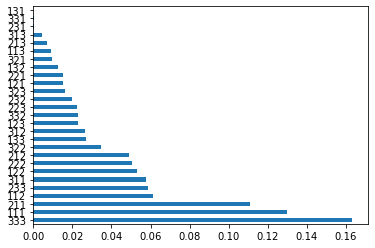

In [273]:
df.RFM.value_counts(normalize=True).plot(kind='barh');